# EPL Player Stats 2024-25: xG Overperformance Analysis

This notebook analyzes Premier League player performance data focusing on Expected Goals (xG) overperformance.

## Goal
Identify the top 10 players who are scoring more goals than their xG suggests - the most clinical finishers.

In [90]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [91]:
# Load the EPL player stats dataset
df = pd.read_csv('../data/fbref_PL_2024-25.csv')

# Display basic info
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (574, 36)


,Rk,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,Gls.1,Ast.1,G+A.1,G-PK.1,G+A-PK,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1
0,1,Max Aarons,eng ENG,DF,Bournemouth,24.0,2000.0,3,1,86,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,Joshua Acheampong,eng ENG,DF,Chelsea,18.0,2006.0,4,2,170,...,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.12,0.12,0.12
2,3,Tyler Adams,us USA,MF,Bournemouth,25.0,1999.0,28,21,1965,...,0.00,0.14,0.14,0.00,0.14,0.07,0.05,0.12,0.07,0.12
3,4,Tosin Adarabioyo,eng ENG,DF,Chelsea,26.0,1997.0,22,15,1409,...,0.06,0.06,0.13,0.06,0.13,0.06,0.01,0.07,0.06,0.07
4,5,Simon Adingra,ci CIV,"FW,MF",Brighton,22.0,2002.0,29,12,1097,...,0.16,0.16,0.33,0.16,0.33,0.20,0.20,0.40,0.20,0.40


In [92]:
#minimum minutes filter
df_filtered = df[df["Min"] >= 900].copy()

print(f"Players before filter: {df.shape[0]}")
print(f"Players after filter: {df_filtered.shape[0]}")


Players before filter: 574
Players after filter: 322


## Calculate xG Overperformance

Formula: **Clinical Finishing = Actual Goals - Expected Goals (xG)**

In [93]:
df_filtered['xG_overperformance'] = df_filtered['Gls'] - df_filtered['xG']
df_filtered[["Player", "Squad", "Min", "Gls", "xG", "xG_overperformance"]].head()

,Player,Squad,Min,Gls,xG,xG_overperformance
2,Tyler Adams,Bournemouth,1965,0,1.6,-1.6
3,Tosin Adarabioyo,Chelsea,1409,1,0.9,0.1
4,Simon Adingra,Brighton,1097,2,2.5,-0.5
5,Emmanuel Agbadou,Wolves,1410,1,0.8,0.2
7,Ola Aina,Nott'ham Forest,2995,2,0.6,1.4


In [94]:
import sqlite3

conn = sqlite3.connect("../data/epl.db")

df_filtered.to_sql(
    "players",
    conn,
    if_exists="replace",
    index=False
)

322

Top 10 xG Overperformers (Clinical Finishers)

In [95]:
pd.read_sql("""
SELECT
  Player,
  Squad,
  Pos,
  Min,
  Gls,
  xG,
  (Gls - xG) AS xG_overperformance
FROM players
ORDER BY xG_overperformance DESC
LIMIT 10;
""", conn)


,Player,Squad,Pos,Min,Gls,xG,xG_overperformance
0,Bryan Mbeumo,Brentford,FW,3414,20,12.3,7.7
1,Chris Wood,Nott'ham Forest,FW,2959,20,13.4,6.6
2,Matheus Cunha,Wolves,"MF,FW",2597,15,8.6,6.4
3,Jarrod Bowen,West Ham,"FW,MF",2973,13,8.6,4.4
4,Alex Iwobi,Fulham,"FW,MF",2981,9,4.7,4.3
5,Mateo Kovačić,Manchester City,MF,2198,6,1.9,4.1
6,Mohamed Salah,Liverpool,FW,3371,29,25.2,3.8
7,Jørgen Strand Larsen,Wolves,FW,2587,14,10.3,3.7
8,Amad Diallo,Manchester Utd,"MF,FW",1901,8,4.7,3.3
9,James Maddison,Tottenham,MF,1809,9,5.8,3.2


Average xG overperformance by position

In [96]:
pd.read_sql("""
Select
    Pos,
    COUNT(*) AS player_count,
    AVG(Gls - xG) AS avg_xg_diff,
    AVG(Gls) AS avg_goals,
    AVG(xG) AS avg_xg
FROM players
WHERE Min >= 900
GROUP BY Pos
ORDER BY avg_xg_diff DESC;""", conn)

,Pos,player_count,avg_xg_diff,avg_goals,avg_xg
0,FW,43,0.448837,9.697674,9.248837
1,"FW,MF",33,0.157576,4.787879,4.630303
2,"MF,DF",9,0.122222,2.000000,1.877778
3,"MF,FW",24,0.100000,4.708333,4.608333
4,"DF,MF",8,0.025000,0.625000,0.600000
5,GK,26,-0.003846,0.000000,0.003846
6,DF,114,-0.180702,0.982456,1.163158
7,MF,62,-0.187097,2.435484,2.622581
8,"FW,DF",1,-0.500000,0.000000,0.500000
9,"DF,FW",2,-1.100000,1.000000,2.100000


xG Under Performance (Players missing chances)

In [97]:
pd.read_sql("""
Select
    Player,
    Squad,
    Pos,
    Gls,
    xG,
    (Gls - xG) AS xg_underperformance,
    Min
FROM players
WHERE Min >= 900
ORDER BY xg_underperformance ASC
LIMIT 10;""", conn)

,Player,Squad,Pos,Gls,xG,xg_underperformance,Min
0,Sávio,Manchester City,"FW,MF",1,5.0,-4.0,1766
1,Cameron Archer,Southampton,FW,2,5.7,-3.7,1441
2,Dominic Calvert-Lewin,Everton,FW,3,6.7,-3.7,1609
3,Eddie Nketiah,Crystal Palace,"FW,MF",3,5.8,-2.8,1034
4,Ismaila Sarr,Crystal Palace,MF,8,10.7,-2.7,2711
5,Noni Madueke,Chelsea,FW,7,9.6,-2.6,2033
6,Evanilson,Bournemouth,FW,10,12.5,-2.5,2319
7,Eberechi Eze,Crystal Palace,"MF,FW",8,10.5,-2.5,2588
8,Jack Harrison,Everton,FW,1,3.5,-2.5,2076
9,Marcus Tavernier,Bournemouth,"FW,MF",3,5.5,-2.5,1939


Team with most efficient finishers:

In [98]:
pd.read_sql("""
SELECT 
    Squad,
    COUNT(*) AS player_count,
    SUM(Gls) AS total_goals,
    SUM(xG) AS total_xg,
    (SUM(Gls) - SUM(xG)) AS team_xg_diff,
    ROUND((SUM(Gls) / SUM(xG)) * 100, 2) AS finishing_efficiency_percent
FROM players
WHERE Min >= 900
GROUP BY Squad
ORDER BY team_xg_diff DESC
LIMIT 10;""",conn)

,Squad,player_count,total_goals,total_xg,team_xg_diff,finishing_efficiency_percent
0,Nott'ham Forest,14,52,41.3,10.7,125.91
1,Wolves,16,46,38.6,7.4,119.17
2,Brentford,14,63,57.4,5.6,109.76
3,Arsenal,16,59,55.3,3.7,106.69
4,Liverpool,15,84,80.5,3.5,104.35
5,Brighton,17,58,54.5,3.5,106.42
6,Tottenham,19,56,52.9,3.1,105.86
7,Newcastle Utd,15,64,61.9,2.1,103.39
8,Leicester City,18,30,29.1,0.9,103.09
9,Fulham,16,46,45.6,0.4,100.88


## Analysis & Visualization

Top 10 most clinical finishers in EPL 2024-25

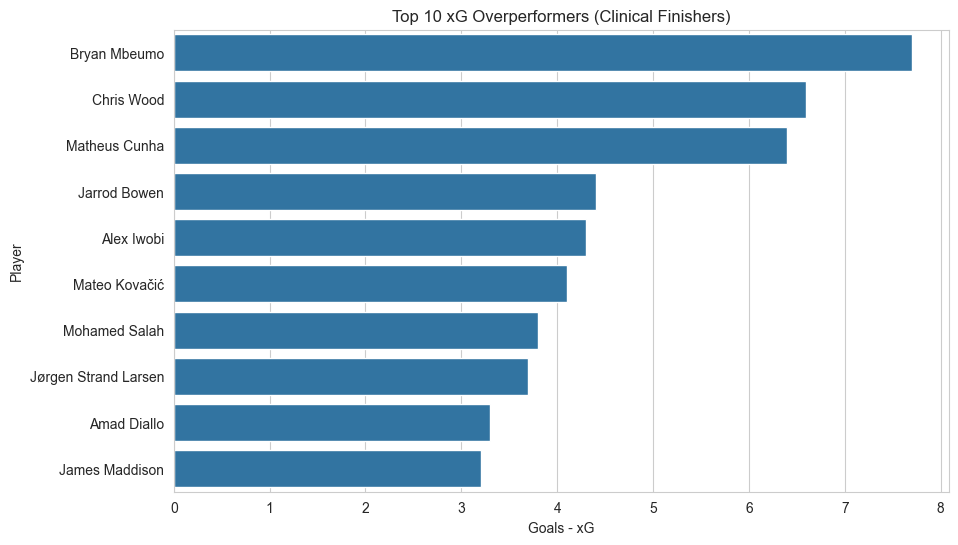

In [99]:
top10 = df_filtered.sort_values("xG_overperformance", ascending=False).head(10)
top10[["Player", "Squad", "Pos", "Gls", "xG", "xG_overperformance"]]

#barplot

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x="xG_overperformance",
    y="Player"
)
plt.title("Top 10 xG Overperformers (Clinical Finishers)")
plt.xlabel("Goals - xG")
plt.ylabel("Player")
plt.savefig("../visuals/top10_xg_overperformers.png", dpi=150, bbox_inches="tight")
plt.show()


In [100]:
#scatterplot
import plotly.express as px
fig = px.scatter(
    df_filtered,
    x="xG",
    y="Gls",
    hover_name="Player",
    hover_data={
        "Squad": True,
        "Pos": True,
        "Min": True,
        "xG": ':.2f',
        "Gls": True,
        "xG_overperformance": ':.2f'
    },
    title="xG vs Goals (Min 900 Minutes Played)"
)

max_val = max(df_filtered["xG"].max(), df_filtered["Gls"].max())
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=max_val, y1=max_val,
    line=dict(dash="dash")
)
fig.write_html("../visuals/xg_vs_goals_interactive.html")
fig.show()